## Singapore population by Gender, Age group
The process of exploring population estimation model

#### *** All population data from Singstat ***

## Sections

### 1. Fertility
#### 1.1 Data Exploring
#### 1.2 Fertility (Time Series Modeling)
#### 1.3 Fertility by Education Level
#### 1.4 Fertility with Marital Status
#### 1.5 Is education the drivers of late marriage or lower fertility rate


### 2. Mortality
#### 2.1 Linear Fitting
#### 2.2 Nonlinear regression

### 3. Population Regression with lag (ACTUAL METHODOLOGY LIES HERE)
#### 3.1 Prepare data
#### 3.2 Predict female population and newborns with fertility


### 4. Generate Prediction
#### 4.1 Object and functions for prediction
#### 4.2 Declare parameters for object
#### 4.3 Show 10- year forecast result

### 5. Validating our methodology and output

### 6. Limitation

### 7. Appendix


In [1]:
import pandas as pd
import re
import math
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
from datetime import datetime
import pickle
warnings.filterwarnings('ignore')
import re


def forecast(data,order,period):
    data = data.astype(float)
#     data = data[~data.isna()]
    prediction = []
    history = list(data)
    for i in range(period):
        model = ARIMA(history,order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        prediction.append(yhat)
        history.append(yhat[0])
    return (model_fit,history)


def evaluate_arima_model(X, order):
        train = X[:int(len(X)*0.8)]
        test = X[int(len(X)*0.8):]
        history = [x for x in train]
        prediction = []
        for i in range(len(test)):
            model = ARIMA(history,order)
            model_fit = model.fit(disp=0)
            yhat = model_fit.forecast()[0]
            history.append(test[i])
            prediction.append(yhat)
        error = mean_squared_error(test,prediction)
        l2 = np.sum((model_fit.arparams)**2)
        return error,l2
    
    
def evaluate_models(data,p_values,d_values,q_values):
    # evaluate_arima_model(temp,(4,1,1))
        data = data.astype(float)
        best_score,best_cfg = float('inf'),None
        best_second = None
#         self.lam = lam
        for p in p_values:
            for d in d_values:
                for q in q_values:
                    order = (p,d,q)
                    try:
                        mse,l2 = evaluate_arima_model(data,order)
                        if (mse) < best_score:
                            best_second = best_cfg
                            best_score,best_l2, best_cfg = mse,l2,order
                        print(f'ARIMA {order} MSE : {mse} , L2 : {l2}')
                    except:
                        continue

        assert best_score != float('inf')
        print('')
        print(f'Best ARIMA {best_cfg} , MSE : {best_score}, L2 : {best_l2}\n')
        return best_cfg,best_second,best_score




class ts_fit:

    def __init__(self):
        pass


    def evaluate_models(self,data,p_values,d_values,q_values,lam):
    # evaluate_arima_model(temp,(4,1,1))
        data = data.astype(float)
        best_score,best_cfg = float('inf'),None
        best_second = None
        self.lam = lam
        for p in p_values:
            for d in d_values:
                for q in q_values:
                    order = (p,d,q)
                    try:
                        mse,l2 = evaluate_arima_model(data,order)
                        if (mse + lam*l2) < best_score:
                            best_second = best_cfg
                            best_score,best_l2, best_cfg = mse,l2,order
                        print(f'ARIMA {order} MSE : {mse} , L2 : {l2}')
                    except:
                        continue

        assert best_score != float('inf')
        print('')
        print(f'Best ARIMA {best_cfg} , MSE : {best_score}, L2 : {best_l2}\n')
        return best_cfg,best_second,best_score,best_l2



    
    
    
    def run_ts(self,data,lam):



        #get best config 
        p_values = [1,2,4,6] #until 4
        d_values = [0,1,2]
        q_values = [0,1,2]

    #     fig,ax = plt.subplots(len(data),1)
        record = []
        model_list = []
        year_of_forecast = 30
        cfg = []
        documentation = ''
        self.doc = f'Lambda : {lam} , highest p : {p_values[-1]} , highest q : {q_values[-1]} \n'
        #start fitting ts
        
        for i,x in enumerate(data):
            print(f'Fitting {x.name} ...')
            try:
                na_from = x[x.isna()].index[-1]
            except:
                na_from = x.index[0]
            x = x.loc[na_from:]
            x = x.iloc[1:]
            cfg += [self.evaluate_models(x,p_values,d_values,q_values,lam )]
            try:
                output = forecast(x,cfg[i][0],year_of_forecast)
                documentation += f'{x.name} : {cfg[i][0]} , MSE : {cfg[i][2]}  ,L2 : {cfg[i][3]} \n'
            except:
                output = forecast(x,cfg[i][1],year_of_forecast)
                documentation += f'{x.name} : {cfg[i][1]} , MSE : {cfg[i][2]}  ,L2 : {cfg[i][3]} \n'

            model_list += [output[0]]
            year = list(x.index)
            last_year = int(year[-1])
            year = [last_year+i for i in np.arange(1,year_of_forecast+1)]
            record += [pd.concat([pd.Series(list(x.index) + year),pd.Series(output[1])],axis=1).rename(columns={0:'year',1:x.name + '_tstrend'})]
    #         ax[i].plot(output[1])
    #         x.plot(ax=ax[i])
        
        self.record = record
        self.model_list = model_list
        self.doc += documentation
        return
    

    
    def document(self,ax):
        now = str(datetime.now().strftime('%Y-%m-%d_%H_%M_%S'))
        ax.figure.savefig('Plots Documentation/'+ now + '.png')
        with open(f'config/{now}.txt','w') as f:
            f.write(self.doc)
        return
    
    
    



def fillnb(series):
    # start from last 
    series = series.apply(lambda x: math.nan if type(x) == str else x)
    for i in np.arange(len(series)-1,0,-1):
        #not filling first one
        if math.isnan(series[i]):
            if i==len(series)-1:
                series[i] = series[i-1]
            else:
                #check if there are two neighbours
                if (math.isnan(series[i-1]) == False) and (math.isnan(series[i+1]) == False):
                    series[i] = (series[i-1] + series[i+1])/2.0
        else:
            continue
    return series



D:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 1.  Fertility  

#### 1.1 Data exploring

In [2]:
fer_rate = pd.read_csv('sg_fertility_rate.csv') #view fertility rate data

Data prior to 1980 pertain to total population. Data from 1980 onwards pertain to resident population (ie Singapore citizens and pr)


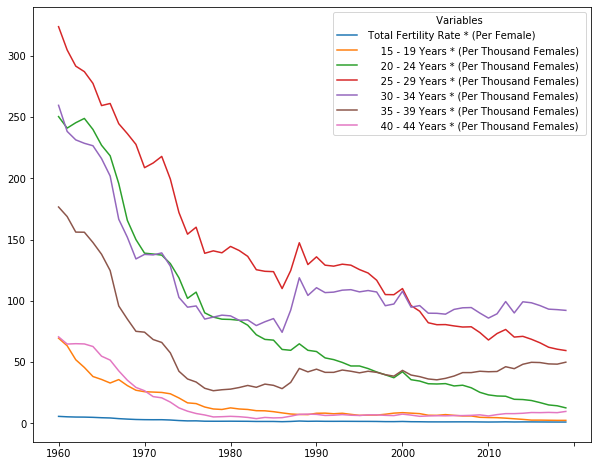

In [9]:
fer_rate_pop = fer_rate.iloc[0:7].transpose()
header = fer_rate_pop.iloc[0]
fer_rate_pop = fer_rate_pop.iloc[1:]
fer_rate_pop.columns = header
fer_rate_pop = fer_rate_pop.astype(float)

fer_rate_pop.plot(figsize=(10,8))

### 1.2  Fertility (Time Series Modelling)

Search for best ARIMA parameters,
take some time to run

In [4]:


p_values = [0,1,2,4,6]
d_values = [0,1,2]
q_values = [0,1,2]

cfg = []

fer_rate_t = fer_rate.iloc[1:7].set_index(' Variables ').transpose()
for col in fer_rate_t.columns:
    fer_rate_t[col] = fer_rate_t[col].apply(lambda x: math.nan if x == ' na ' else x).astype(float)


for col in fer_rate_t.columns:
    cfg += [evaluate_models(fer_rate_t[col].iloc[30:],p_values,d_values,q_values )] #start after 30 years because there's a change in trend after 1980
    

ARIMA (0, 0, 0) MSE : 14.00684150180308 , L2 : 0.0
ARIMA (0, 0, 1) MSE : 4.36652189376181 , L2 : 0.0
ARIMA (0, 1, 0) MSE : 0.06079563875147689 , L2 : 0.0
ARIMA (0, 1, 1) MSE : 0.05253535848244386 , L2 : 0.0
ARIMA (0, 1, 2) MSE : 0.061082421016770284 , L2 : 0.0
ARIMA (0, 2, 0) MSE : 0.07047819287659415 , L2 : 0.0
ARIMA (0, 2, 1) MSE : 0.10547134062181006 , L2 : 0.0
ARIMA (0, 2, 2) MSE : 0.08869962475491665 , L2 : 0.0
ARIMA (1, 0, 0) MSE : 0.16252575606173691 , L2 : 0.9544652642562629
ARIMA (1, 0, 1) MSE : 0.13955427934616152 , L2 : 0.9142508283553409
ARIMA (1, 1, 0) MSE : 0.05307951514937149 , L2 : 0.02764122922809074
ARIMA (1, 1, 1) MSE : 0.06318186452796766 , L2 : 0.2385524362500763
ARIMA (1, 1, 2) MSE : 0.0850746209196352 , L2 : 0.18765536069354888
ARIMA (1, 2, 0) MSE : 0.06416013020621926 , L2 : 0.12414264069163015
ARIMA (1, 2, 1) MSE : 0.08889132056684013 , L2 : 0.033100136883972155
ARIMA (1, 2, 2) MSE : 0.1054345609677904 , L2 : 0.21740493534322958
ARIMA (2, 0, 0) MSE : 0.13420677

ARIMA (6, 0, 0) MSE : 17.950850337691076 , L2 : 0.3215975609458672
ARIMA (6, 0, 1) MSE : 35.783688569226264 , L2 : 1.879422560251117
ARIMA (6, 1, 0) MSE : 33.871931182438786 , L2 : 0.423188635181935
ARIMA (6, 1, 1) MSE : 34.1401735601255 , L2 : 0.03975085632953604
ARIMA (6, 1, 2) MSE : 62.0393799714723 , L2 : 1.602266506241421

Best ARIMA (1, 0, 1) , MSE : 5.720321646218032, L2 : 0.8469285101965031

ARIMA (0, 0, 0) MSE : 53.755640986040724 , L2 : 0.0
ARIMA (0, 0, 1) MSE : 23.381733674039385 , L2 : 0.0
ARIMA (0, 0, 2) MSE : 14.8841209809568 , L2 : 0.0
ARIMA (0, 1, 0) MSE : 3.170216965921219 , L2 : 0.0
ARIMA (0, 1, 1) MSE : 3.297761498156923 , L2 : 0.0
ARIMA (0, 1, 2) MSE : 3.855886204039009 , L2 : 0.0
ARIMA (0, 2, 0) MSE : 6.708381576545679 , L2 : 0.0
ARIMA (0, 2, 1) MSE : 3.127093241735217 , L2 : 0.0
ARIMA (1, 0, 0) MSE : 5.533760489882595 , L2 : 0.7565663103521554
ARIMA (1, 0, 1) MSE : 5.6515042197388015 , L2 : 0.7849242468559224
ARIMA (1, 0, 2) MSE : 6.125703113707535 , L2 : 0.765045

With the best parameters, predict next 10 years of fertility rate

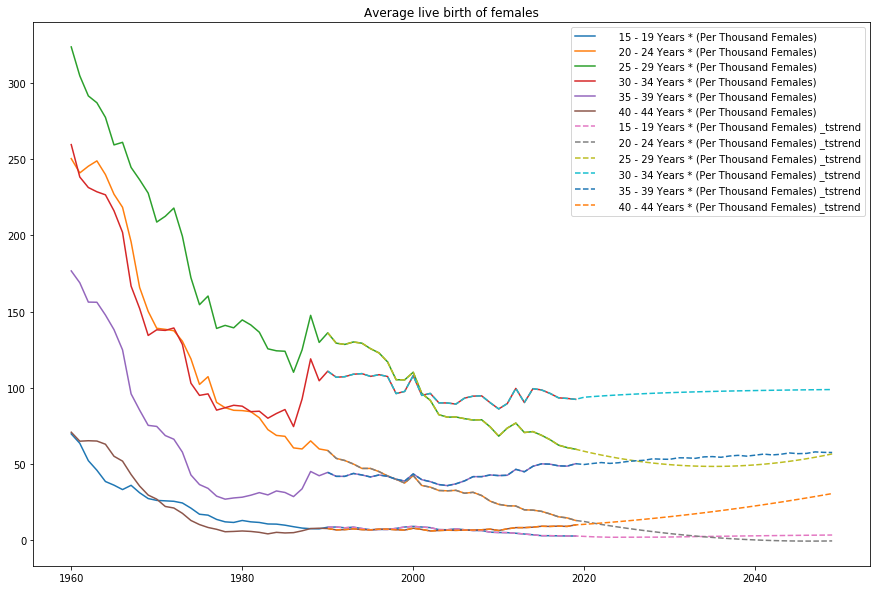

In [6]:


record = []
model_list = []
year_of_forecast = 30
for i,col in enumerate(fer_rate_t.columns):
    x = fer_rate_t[col]
    output = forecast(x[30:],cfg[i][0],year_of_forecast)
    model_list += [output[0]]
    year = list(x[30:].index)
    last_year = int(year[-1])
    year = [last_year+i for i in np.arange(1,year_of_forecast+1)]
    record += [pd.concat([pd.Series(list(x[30:].index) + year).astype(str),pd.Series(output[1])],axis=1).rename(columns={0:'year',1:x.name + '_tstrend'})]

fer_rate_ts = fer_rate_t.copy()
for col in record:
    fer_rate_ts = pd.concat([fer_rate_ts,col.set_index('year')],axis=1)


fer_rate_ts.plot(figsize=(15,10),title='Average live birth of females',style=dict(zip(fer_rate_ts.columns[-len(record):], ['--']*len(fer_rate_ts.columns[-len(record):]))))

In [7]:
for col in fer_rate_ts:
    fer_rate_ts[col] =  fer_rate_ts[col].apply(lambda x: 0 if (math.isnan(x) == False)&( x <0) else x )

Conclusion : The fertility rate of 15-19 ,20-24 converged and nearest to 0.

### 1.3 Fertility by Education level 
##### Ad Hoc Analysis

From [A Guide to Global Population Projections](demographic-research.org/volumes/vol4/8/4-8.pdf) , it is unlikely that fertility to remain extremely low, especially if societies made it easier for women to combine careers and chilbearing.
Low fertility countries generally converge to levels between 1.7 and 2.0

Hypothesis : If the population of female STUDENTS converged, the fertility rate of young female should already at an eventual level (converging point).




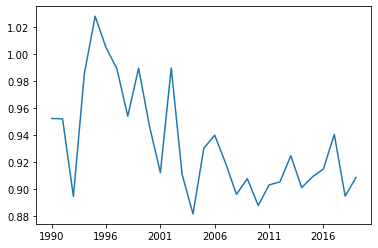

In [13]:
fer_edu_t = pd.read_csv('sg_fertility_education(per ever married40-49).csv').transpose()
header = fer_edu_t.iloc[0]
fer_edu_t = fer_edu_t.iloc[1:]
fer_edu_t.columns = header
fer_edu_t['uni_non_uni_ratio'] = fer_edu_t.iloc[:,-1]/fer_edu_t.iloc[:,-3]
fer_edu_t['uni_non_uni_ratio'].plot()

To support the hypothesis that university education leads to drop in fertility rate in female.
The fertility rate used is per resident ever-married female aged 40-49, by different highest academic qualification

We observed the ratio of the fertility rate of Uni qualification female , and Post Secondary qualification female has dropped , from 40-49 females.



#### Converging of female university attendances

Once log the numbers, we can see younger generation student numbers converging to 11, followed by other age groups

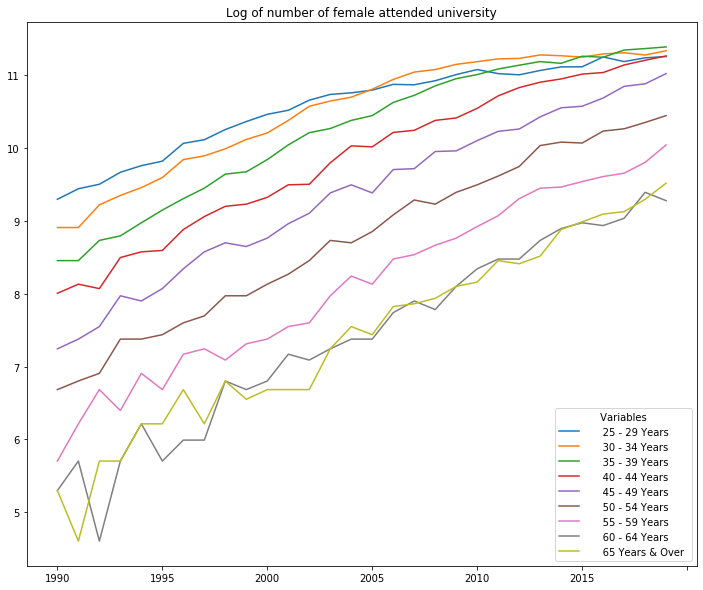

In [37]:
edu = pd.read_csv('pop_education.csv')

edu_t = edu.iloc[170:].transpose()
header = edu_t.iloc[0]
edu_t = edu_t.iloc[1:]
edu_t.columns = header

def f(x):
    if ',' in x:
        return (int(re.sub(',','',x)))
    else:
        return int(x)

for col in edu_t.columns:
    edu_t[col] = edu_t[col].apply(lambda x: math.log(f(x) ))
    
edu_t = edu_t.drop(columns=' University ')

edu_t.plot(figsize=(12,10),title='Log of number of female attended university')

We show that the fit of growth in female attendances in university could possible related to converging in fertility rate

Text(0.5, 1.0, 'Derivative of university proportion')

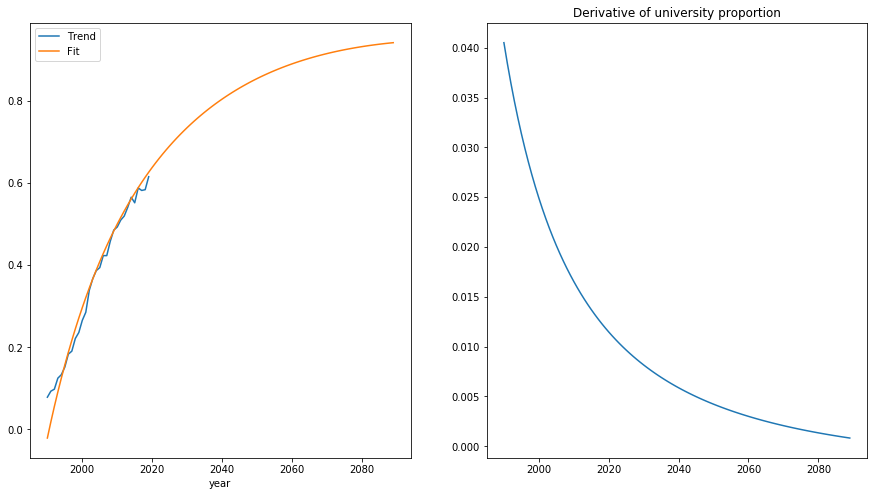

In [34]:


total_female_2529  = edu.iloc[121]
total_female_2529 = total_female_2529.iloc[1:].apply(lambda x: int(re.sub(',','',x)))
uni_perc = (edu_t.iloc[:,0].apply(lambda x: math.exp(x)) / total_female_2529)


x = 1990 + np.arange(0,100)

unitrend_func = lambda x: 0.38*(10*(math.log((x - 1960))) - (math.log(x-1960)**2))  - 8.55
unitrend = [unitrend_func(i) for i in x]

x = 1990 + np.arange(0,100)
unitrend_dx_func = lambda x: (3.8 - 2*0.38*math.log(x-1960))/(x-1960)
unitrend_dx2_func = lambda x: (3.8 - 2*0.38*math.log(x-1960))/(x-1960)
unitrend_dx = [unitrend_dx_func(i) for i in x]


fig,ax = plt.subplots(1,2,figsize=(15,8))
pd.concat([uni_perc.rename('Trend').reset_index(),pd.Series(unitrend),pd.Series(x)],axis=1).rename(columns={0:'Fit',1:'year'}).set_index('year').plot(ax=ax[0])
ax[1].plot(x,unitrend_dx)
ax[1].set_title('Derivative of university proportion')

Text(0.5, 1.0, 'Derivative of trend 25-29')

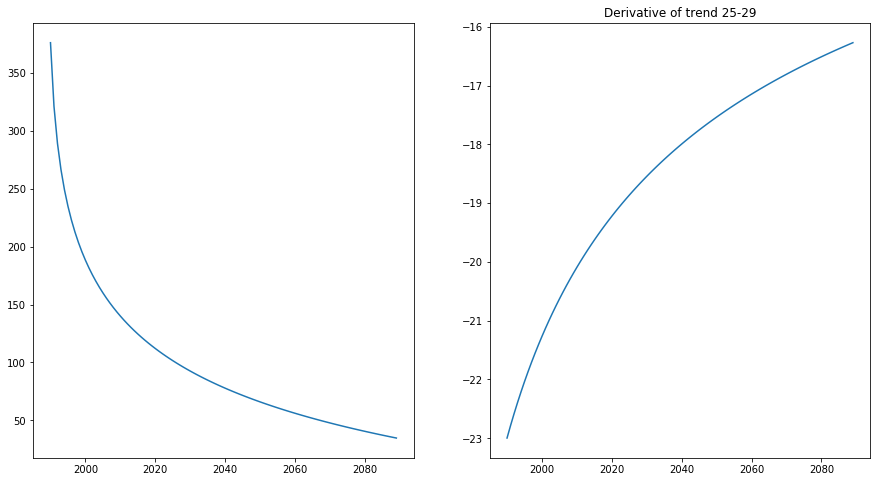

In [211]:
fig,ax = plt.subplots(1,2,figsize=(15,8))
ax[0].plot(x,trend_2529)

trend_2529_dx_func = lambda x: -80/(math.log(x-1959)) + 6*math.log(x-1900)/(x-1900)
trend_2529_dx = [trend_2529_dx_func(i) for i in x]

ax[1].plot(x,trend_2529_dx)
ax[1].set_title('Derivative of trend 25-29')

# ax[0].plot(tmp)

In [214]:
beta1 = np.cov(unitrend[:30],trend_2529[:30])[0,1]/np.cov(unitrend[:30])
beta0 = np.mean(trend_2529[:30]) - beta1 * np.mean(unitrend[:30])

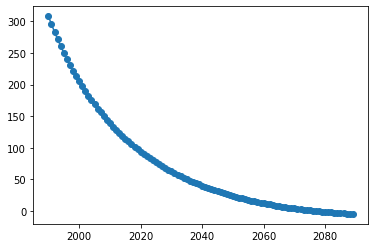

In [240]:
plt.plot(x,[beta0 + beta1*i for i in unitrend],'-o')

In [751]:
tmp = [trend_2529[0]]
for y in x[1:]:
    tmp += [tmp[-1] + trend_2529_dx_func(y)]

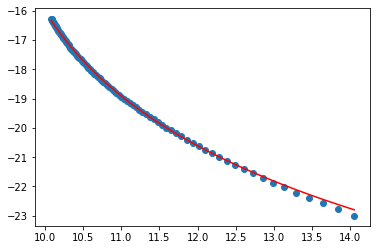

In [729]:

unitrend_dx_scale = lambda x: x*100 + 10
# derivative_map_func = lambda x: -2.88*math.log(x-0.01) - 19 
derivative_map_func = lambda x: -4.2*math.log(x - 9)  - 16
plt.scatter([unitrend_dx_scale(i) for i in unitrend_dx],trend_2529_dx)
plt.plot([unitrend_dx_scale(i) for i in unitrend_dx],[derivative_map_func(i) for i in [unitrend_dx_scale(i) for i in unitrend_dx]],color='red')
# trend_func = lambda x: -0.18*math.log(x -1989)+2.3



In [738]:
get_derivative = lambda x: derivative_map_func(unitrend_dx_scale(unitrend_dx_func(x)))
predict_livebirth2529 = lambda year: average_livebirth25_29_trend(year-1)*(get_derivative(year))

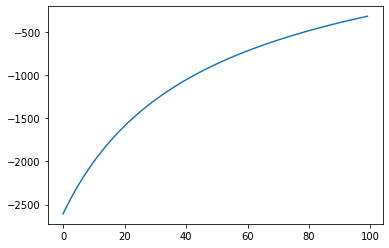

In [757]:
plt.plot([predict_livebirth2529(y ) for y in x])

### 1.4 Fertility with Marital status

##### Ad Hoc Analysis

Female status married in 20-29, doesnt have 25-29 age band, we should estimate a portion of married female from here.
Why not estimate 20-29 fertility rate , because the university level education rate is similar , but 20-24 fertility rate is way lower.

In [181]:
marital = pd.read_csv('marital_status_age.csv')

In [182]:
# marital[marital[' Variables '] == ' Females Aged 20-29 Years ']
##at row 10
marital_t = marital.iloc[12:13].transpose()
header = marital_t.iloc[0]
marital_t.columns = header
marital_t = marital_t.iloc[1:]
for col in marital_t.columns:
    marital_t[col] = marital_t[col].apply(lambda x: int(re.sub(',','',x)))


Estimate 25-29 number of married as a portion from 20-29.

In [183]:
temp = fer_rate_t[fer_rate_t.columns[1:3]]
temp['sum'] = temp.sum(axis=1)
temp = (temp[temp.columns[1]] / temp['sum']).iloc[20:]

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [184]:
marital_2529 = pd.concat([marital.iloc[10].iloc[9:].apply(lambda x: int(re.sub(',','',x))), total_female_2529,temp],axis=1).rename(columns={10:'20-29_total',121:'25-29',0:'marriage_portion'})
marital_2529['25-29_num_of_married'] = marital_2529['25-29'] * marital_2529['marriage_portion']

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


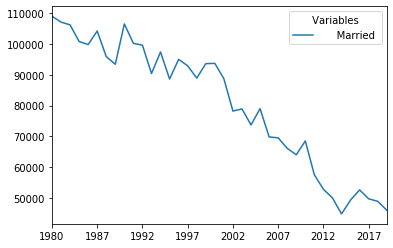

In [435]:
marital_t.plot()

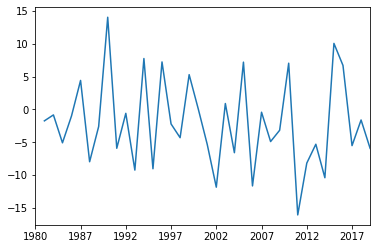

In [431]:
((marital_t.iloc[:,0] - marital_t.iloc[:,1])/marital_t.iloc[:,1]*100).plot()

For fertility, we can focus on 3 age band female, 25-29, 30-34, 35-39 ( from figure 3), because the other age band female would have low fertility, 12.7 for 20-24, 9.8 for 40-44 per thousand of female , we have no 20-24 from the data, but based on 25-29 total males : 126500, and total females 25-29 : 125,700 , which is 49.8% , we can attain from half of the 20-24 population in 2019 : 249080 , using 12.7 for next year per thousand life birth , it will be 1581

### 1.5 Is education the drivers of late marriage or lower fertility rate

##### Ad Hoc Analysis


University percentage is increasing linearly from our data, but what we expect it to be is a non linear trend. So even though it is higly linearly correlated, we cannot use linear regression to regress for the future average life birth in 25-29, because university percentage doesnt increase linearly to 1.




oldnotes:
40-49 yo female in 2019 would be 20-29 in 2000,which is the year we have seen the average number of live birth of 25-29 being surpassed by 30-34

Does education delays preferred reproduction age






In [277]:


edu_t = edu.iloc[170:].transpose()
header = edu_t.iloc[0]
edu_t = edu_t.iloc[1:]
edu_t.columns = header

#25-29, 30-34 yearly university graduate vs average number of live birth in the same year
for i in [1,2]:
    print(np.corrcoef(edu_t.iloc[:,i].apply(lambda x: int(re.sub(',','',x))).to_numpy(),fer_rate_t.iloc[30:,i+1].to_numpy()))

[[ 1.         -0.98179009]
 [-0.98179009  1.        ]]
[[ 1.         -0.73820217]
 [-0.73820217  1.        ]]


To estimate the fertility rate of 25-29, we can split into married, non married.

Then estimate how many percent of married are uni level, this portion is a variable.

Then we have two average number of life birth (also variable), if using fertility rate, we have to know how many married woman will bear child for both education level.


Once fertility reaches its eventual level, assuming mortality and migration rates are also fixed, the population will eventually reach a stable age structure and constant growth rate.



## 2. Mortality

#### Read Files

In [3]:
life_expt = pd.read_csv('sg_life_expectancy.csv')

In [4]:
mortality = pd.read_csv('sg_mortality_rate_1000.csv')

#### Feature engineering

In [5]:
male_dr = mortality.iloc[24:25,:].transpose()
header  = male_dr.iloc[0]
male_dr.columns = header
male_dr = male_dr.iloc[1:]

female_dr = mortality.iloc[48:49,:].transpose()
header  = female_dr.iloc[0]
female_dr.columns = header
female_dr = female_dr.iloc[1:]



Male data

In [6]:
male_age_dr = mortality.iloc[25:48].transpose()
header = male_age_dr.iloc[0]
male_age_dr.columns = header
male_age_dr = male_age_dr.iloc[1:]

def replacena(x):
    if x in [' na ',' - ']:
        return math.nan
    else:
        return x
    
for col in male_age_dr:
    male_age_dr[col] = male_age_dr[col].apply(lambda x: replacena(x)).apply(lambda x: float(x))

Female data

In [7]:
female_age_dr = mortality.iloc[49:,:].transpose()
header = female_age_dr.iloc[0]
female_age_dr.columns = header
female_age_dr = female_age_dr.iloc[1:]

for col in female_age_dr:
    female_age_dr[col] = female_age_dr[col].apply(lambda x: replacena(x)).apply(lambda x: float(x))

for female, 0.1 is the lower bound of mortality rate, for male: 0.2,  0.1 higher than female

### 2.1 Linear fitting
#### Let's see if there are linear
##### Ad Hoc Analysis



In [14]:
def reg_col(col):
    assert type(col) == pd.core.series.Series
    reset_col = col.reset_index(drop=True)
    nan_index = list(reset_col[reset_col.isna()].index)
    for ind in nan_index:
        if (ind != 0) and (ind != len(reset_col)-1):
            reset_col[ind] = (reset_col[ind-1] + reset_col[ind+1])/2
        else:
            try:
                reset_col[ind] = reset_col[ind+1]
            except:
                reset_col[ind] = reset_col[ind-1]
    reset_col.index = col.index
    col = reset_col
    x = np.asarray(col.index).astype(int)
    y = np.asarray(col).astype(float)
    beta1 = np.cov(x,y)[0,1]/np.cov(x,x)[0,0]
    beta0 = np.mean(y) - beta1*np.mean(x)
    return (beta0,beta1)




In [15]:
b0,b1= reg_col(male_age_dr.iloc[:,6])

In [16]:
# male_age_dr.iloc[:,6].plot()
# plt.plot(male_age_dr.iloc[:,6].index,[b0 + b1*x for x in np.array(male_age_dr.iloc[:,6].index).astype(int)])

col_est = {}
for col in male_age_dr.columns[6:15]:
    l = 1960 + np.arange(0,80)
    b0,b1 = reg_col(male_age_dr[col])
    temp = []
    for i in l:
        out = b0 + i*b1
        if out<0:
            out = 0.2
        temp += [out]
    temp = pd.Series(temp)
    temp.index = l.astype(str)
    col_est[col + '_est'] = temp
    

We see that the trend is not linear , there's this slow down after 2010 for few age band

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


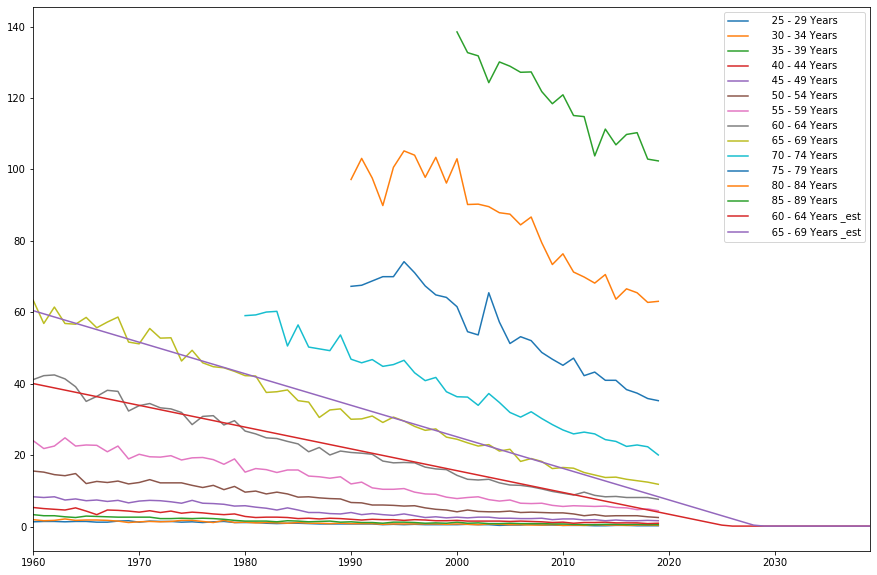

In [190]:
pd.concat([male_age_dr.iloc[:,6:-4],pd.Series(col_est[list(col_est.keys())[-2]]),pd.Series(col_est[list(col_est.keys())[-1]])],axis=1).rename(columns={0:list(col_est.keys())[-2],1:list(col_est.keys())[-1]}).plot(figsize=(15,10))

### 2.2  Nonlinear Regression

We found out that non linear fitting is more realistic

In [8]:
def nonlinear_reg_col(col):
    assert type(col) == pd.core.series.Series
    reset_col = col.reset_index(drop=True)
    nan_index = list(reset_col[reset_col.isna()].index)
    for ind in nan_index:
        if (ind != 0) and (ind != len(reset_col)-1):
            reset_col[ind] = (reset_col[ind-1] + reset_col[ind+1])/2
        else:
            try:
                reset_col[ind] = reset_col[ind+1]
            except:
                reset_col[ind] = reset_col[ind-1]
    reset_col.index = col.index
    col = reset_col[~reset_col.isna()]
    x = np.asarray(col.index).astype(int)
    y = np.log(np.asarray(col).astype(float))
    beta1 = np.cov(x,y)[0,1]/np.cov(x,x)[0,0]
    beta0 = np.mean(y) - beta1*np.mean(x)
    return (beta0,beta1)


In [9]:

col_est = {}
for col in male_age_dr.columns[:19]:
    l = 1960 + np.arange(0,80)
    b0,b1 = nonlinear_reg_col(male_age_dr[col])
    temp = []
    for i in l:
        out = np.exp(b0 + i*b1)
        if out<0:
            out = 0.2
        temp += [out]
    temp = pd.Series(temp)
    temp.index = l.astype(str)
    col_est[col] = temp


male_mortality = male_age_dr.iloc[:,10:15]
for name,col in col_est.items():
    male_mortality = pd.concat([male_mortality,col],axis=1).rename(columns={0:name})

In [15]:

col_est = {}
for col in female_age_dr.columns[:19]:
    l = 1960 + np.arange(0,80)
    b0,b1 = nonlinear_reg_col(female_age_dr[col])
    temp = []
    for i in l:
        out = np.exp(b0 + i*b1)
        if out<0:
            out = 0.2
        temp += [out]
    temp = pd.Series(temp)
    temp.index = l.astype(str)
    col_est[col] = temp


# female_mortality = female_age_dr.iloc[:,10:19]
female_mortality = pd.DataFrame()
for name,col in col_est.items():
    female_mortality = pd.concat([female_mortality,col],axis=1).rename(columns={0:name})

Next we will sub those mortality numbers with actual number as possible.

In [16]:
for col in female_mortality.columns:
    for y in female_mortality[col].index:
        if y not in list(female_age_dr.index):
            pass
        else:
            if math.isnan(female_age_dr[col].loc[y]) == False:
                female_mortality[col].loc[y] = female_age_dr[col].loc[y]
            
for col in male_mortality.columns:
    for y in male_mortality[col].index:
        if y not in list(male_age_dr.index):
            pass
        else:
            if math.isnan(male_age_dr[col].loc[y]) == False:
                male_mortality[col].loc[y] = male_age_dr[col].loc[y]
            

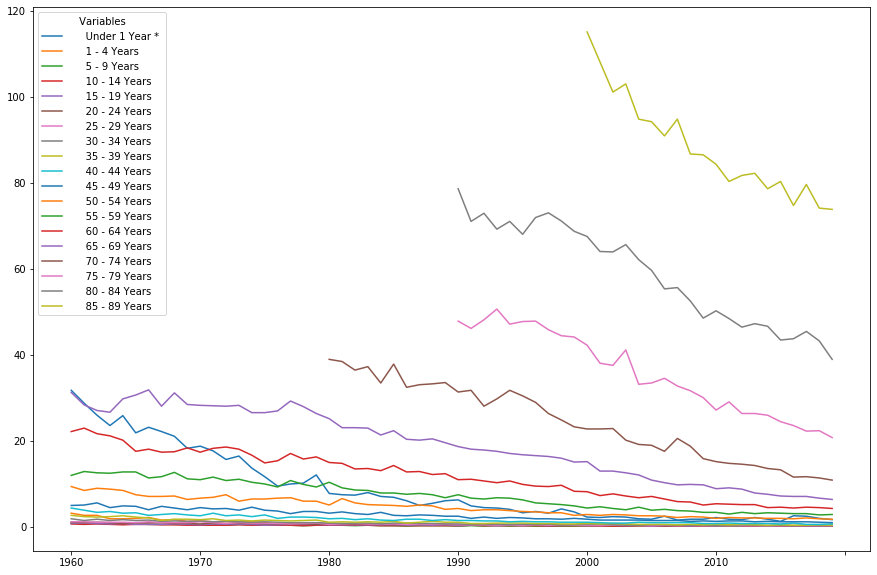

In [22]:
female_age_dr.iloc[:,:19].plot(figsize=(15,10))

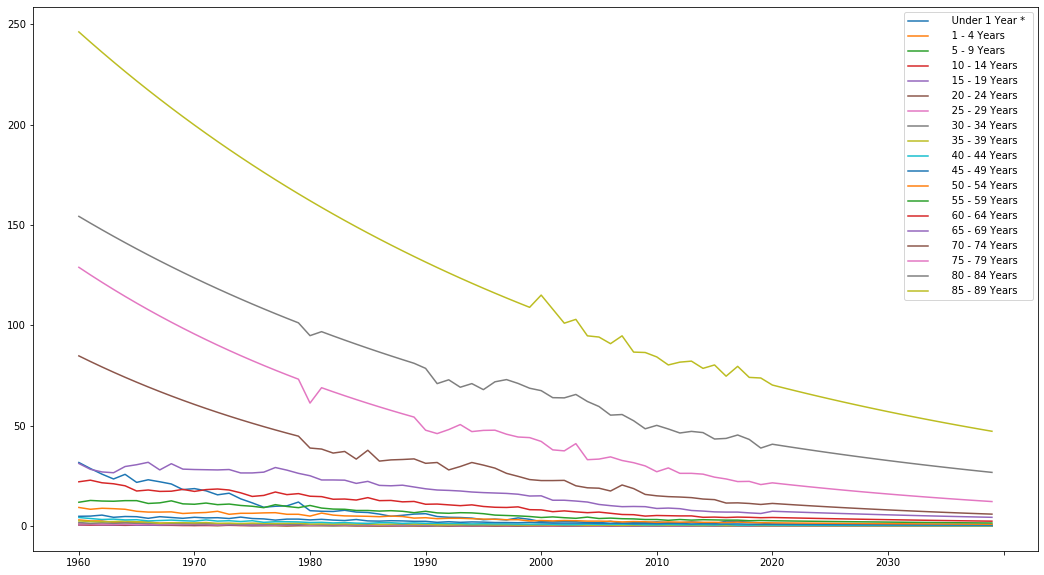

In [1061]:
female_mortality.plot(figsize=(18,10))

If we compare male and female mortality rate, female is lower than male, so perhaps its better to predict population by gender, and for newborns we just split half

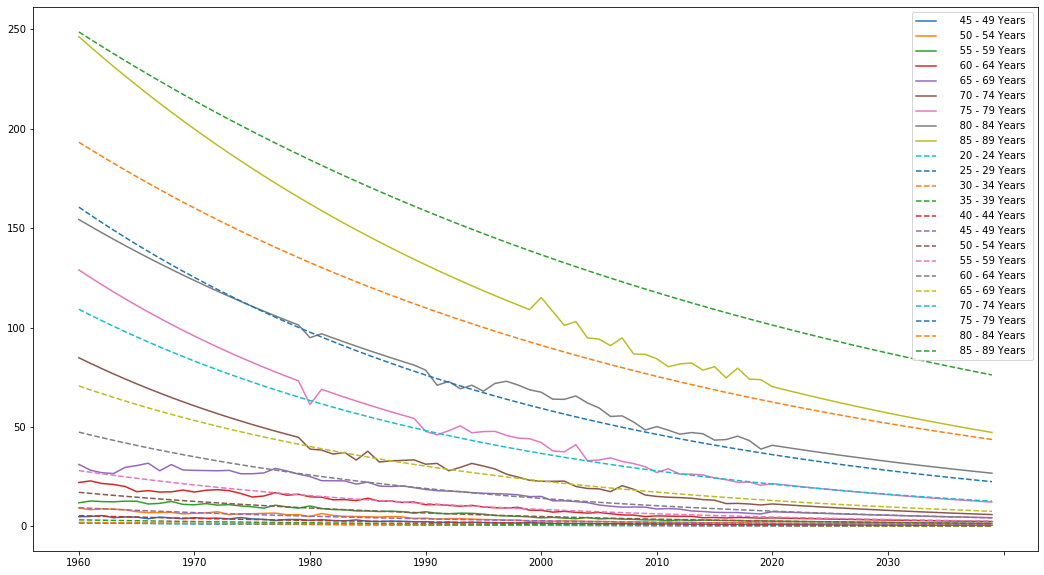

In [25]:
ax = female_mortality.iloc[:,10:].plot(figsize=(18,10))
male_mortality.iloc[:,10:].plot(ax=ax,style=dict(zip(male_mortality.columns,['--']*len(male_mortality.columns))))

### 3.  Population regression with lags


#### We eventually stick with this idea, instead of using *mortality rate data*

The support of this method is in Appendix.

#### 3.1 Prepare data

In [3]:
pop_gender = pd.read_excel('pop_by_gender.xlsx',skiprows=5).iloc[:75,:]
female_pop = pop_gender.iloc[list(range(51,69))+[-1],:]
male_pop = pop_gender.iloc[list(range(26,44))+[-1],:]

female_pop = female_pop.set_index('Variables').transpose()

# GET ACTUAL LIFE BIRTH
totallifebirth = fer_rate.set_index(' Variables ').loc[' Total Live-births (Number) '].apply(lambda x: int(re.sub(',','',x)))


for col in female_pop.columns:
    female_pop[col] = fillnb(female_pop[col])
    
male_pop = male_pop.set_index('Variables').transpose()

for col in male_pop.columns:
    male_pop[col] = fillnb(male_pop[col])
    

#### 3.2 Predict female population and newborns using fertlity.

Here we will do step by step of the thought process.

1. Remove newborns from 0-4 group
2. Get betas of female population
3. Predict female population using 5 year lag
4. Showcase 5 year forecast
5. Further the forecast into 10 years by working on fertility progression
6. Use predicted newborns to predict 1-4 year old group 

In [6]:
import pandas as pd
import re
import math
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
from datetime import datetime
import pickle
warnings.filterwarnings('ignore')
import re


def backward_reg(col1,col2):
    col1 = fillnb(col1)
    col1 = col1.apply(lambda x: math.nan if type(x) ==str else x).to_numpy()
    col2 = fillnb(col2)
    col2 = col2.apply(lambda x: math.nan if type(x) ==str else x)
    col2 = col2.shift(-5).to_numpy()

    temp = col1*col2
    tmp2 = np.array([math.isnan(i) for i in temp ])
    x = col1[tmp2==False]
    y = col2[tmp2==False]
    beta1 = np.cov(x,y)[0,1]/np.cov(x)
    beta0 = np.mean(y) - beta1*np.mean(x)
    return beta0,beta1

def pop_forecast(beta, col,period,intercept=True):
    output = []
    col = fillnb(col)
    for y in col.index:

        if intercept:

            output += [(str(int(y)+period),col.loc[y]*beta[1] + beta[0])]
        else:

            output += [(str(int(y)+period),col.loc[y]*beta[0])]
        
    return output

def backward_reg2(col1,col2,reg,intercept=True):
    col1 = fillnb(col1)
    col1 = col1.apply(lambda x: math.nan if type(x) ==str else x)
    col2 = fillnb(col2) #col2 is y
    col2 = col2.apply(lambda x: math.nan if type(x) ==str else x)
    
    if type(reg) == int:
        x = col2.copy()
        x = pd.concat([x,col1.shift(reg)],axis=1) #col2 is later age group
        reg = [reg]
    
    else:
        x = col2
        for i in reg:
            x = pd.concat([x,col1.shift(i)],axis=1)
    x = x.to_numpy()
    x = x[[sum([math.isnan(i) for i  in row]) == 0 for row in x]]
    y = x[:,0]
    x = x[:,1:]
    
    if intercept:
        x = np.append(np.zeros((len(x),1)) + 1,x,axis=1)

    beta = np.dot(np.linalg.inv(np.dot(x.T,x)), np.dot(x.T,y))
    return beta


def prepare_x(col,period,intercept=True):
    if type(period) == int:
        x = col.shift(period) #col2 is later age group

    
    else:
        x = pd.DataFrame()
        for i in period:
            x = pd.concat([x,col.shift(i)],axis=1)
    x = x.to_numpy()
    x = x[[sum([math.isnan(i) for i  in row]) == 0 for row in x]]
    
    if intercept:
        x = np.append(np.zeros((len(x),1)) + 1,x,axis=1)
    return x



def fillnb(series):
    # start from last 
    series = series.apply(lambda x: math.nan if type(x) == str else x)
    for i in np.arange(len(series)-1,0,-1):
        #not filling first one
        if math.isnan(series[i]):
            if i==len(series)-1:
                series[i] = series[i-1]
            else:
                #check if there are two neighbours
                if (math.isnan(series[i-1]) == False) and (math.isnan(series[i+1]) == False):
                    series[i] = (series[i-1] + series[i+1])/2.0
        else:
            continue
    return series



##### 1. Remove newborns from 0-4 group

In [6]:
female_pop.iloc[:,0] = female_pop.iloc[:,0] - totallifebirth/2
female_pop = female_pop.rename(columns={ '0 - 4 Years' : ' 1 - 4 Years'})

##### 2. Get betas of female population

In [48]:
betas = {}
for ncol in range(1,len(female_pop.columns)):
    betas[female_pop.iloc[:,ncol].name] = backward_reg2(female_pop.iloc[:,ncol-1],female_pop.iloc[:,ncol],reg=[1,2,3],intercept=False)

#### **Regress on lag 1 of previous age group not as fitted as lag 5

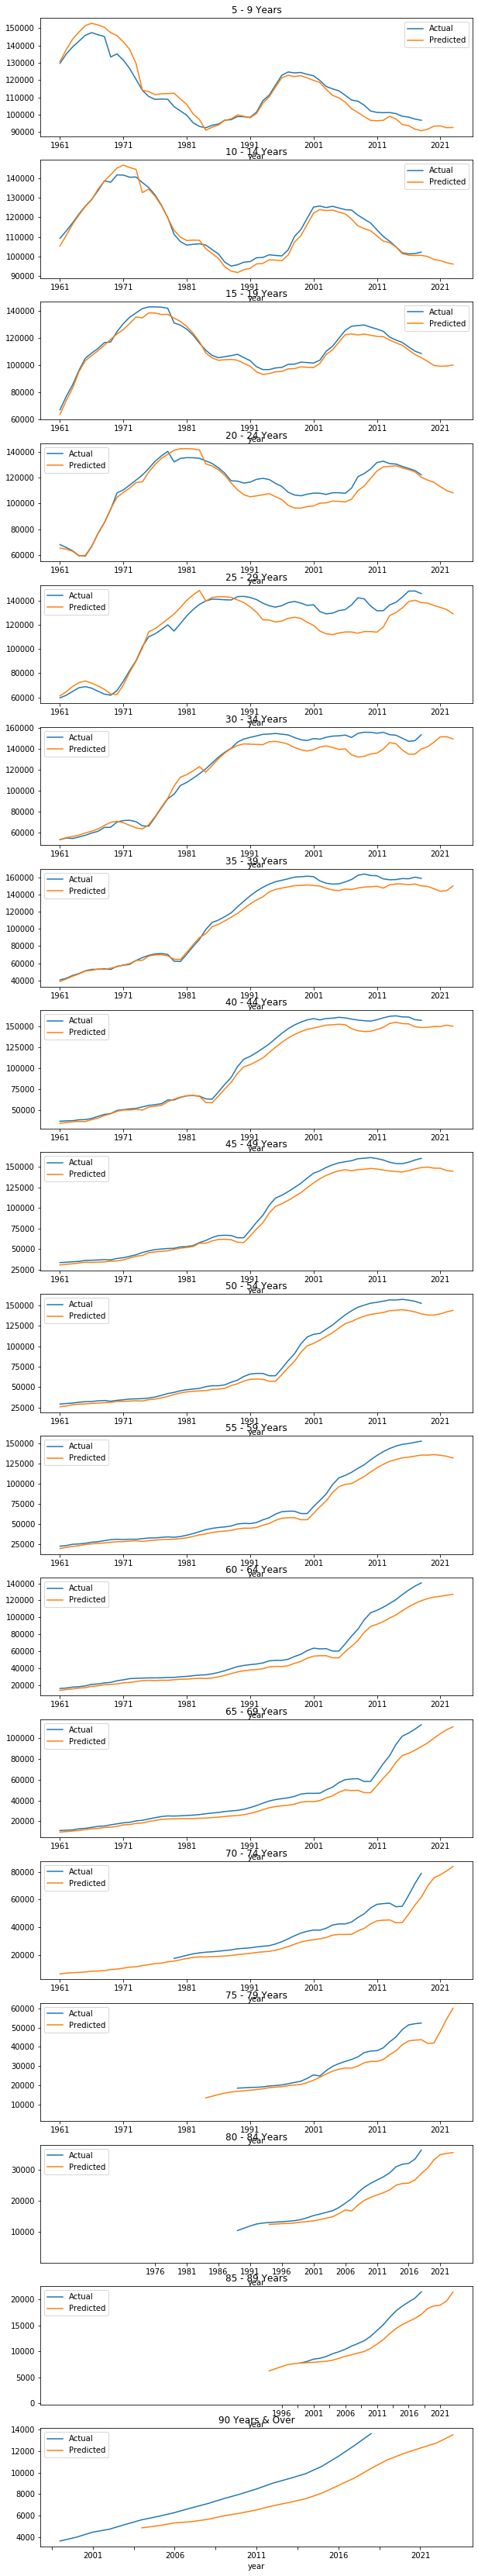

In [53]:
betas = {}
for ncol in range(1,len(female_pop.columns)):
    betas[female_pop.iloc[:,ncol].name] = backward_reg2(female_pop.iloc[:,ncol-1],female_pop.iloc[:,ncol],reg=1,intercept=False)
    


fm_predicted = pd.DataFrame()
for ncol in range(1,len(female_pop.columns)):
    fm_predicted = pd.concat([fm_predicted,pd.DataFrame(pop_forecast(betas[female_pop.iloc[:,ncol].name],female_pop.iloc[:,ncol-1],4,intercept=False)).rename(columns={0:'year',1:female_pop.iloc[:,ncol].name}).set_index('year')],axis=1)
    
fig,ax = plt.subplots(len(female_pop.columns)-1,1,figsize=(10,60))
for i in range(len(female_pop.columns)-1):
    female_pop.loc['1962':].iloc[:,1:].iloc[:,i].plot(ax=ax[i])
    fm_predicted.iloc[:,i].plot(ax=ax[i])
    ax[i].set_title(fm_predicted.iloc[:,i].name)
    ax[i].legend(['Actual','Predicted'])

##### 3. Predict female numbers using previous 5 year lag number of younger age group, our data is until 2019, we are able to predict until 2024 for now

In [28]:

fm_predicted = pd.DataFrame()
for ncol in range(1,len(female_pop.columns)):
    fm_predicted = pd.concat([fm_predicted,pd.DataFrame(pop_forecast(betas[female_pop.iloc[:,ncol].name],female_pop.iloc[:,ncol-1],4,intercept=False)).rename(columns={0:'year',1:female_pop.iloc[:,ncol].name}).set_index('year')],axis=1)

We have used 5 years of gap for prediction, so we could get prediction until 2024.
Since we are using actual number and output fitted values, we dont apply mortality rate , but during regression we assume mortality rate is average across years. Which can be a problem.

One improvement can be done is that we apply mortality rate on it, and do prediction again.

##### 4. Showcase result

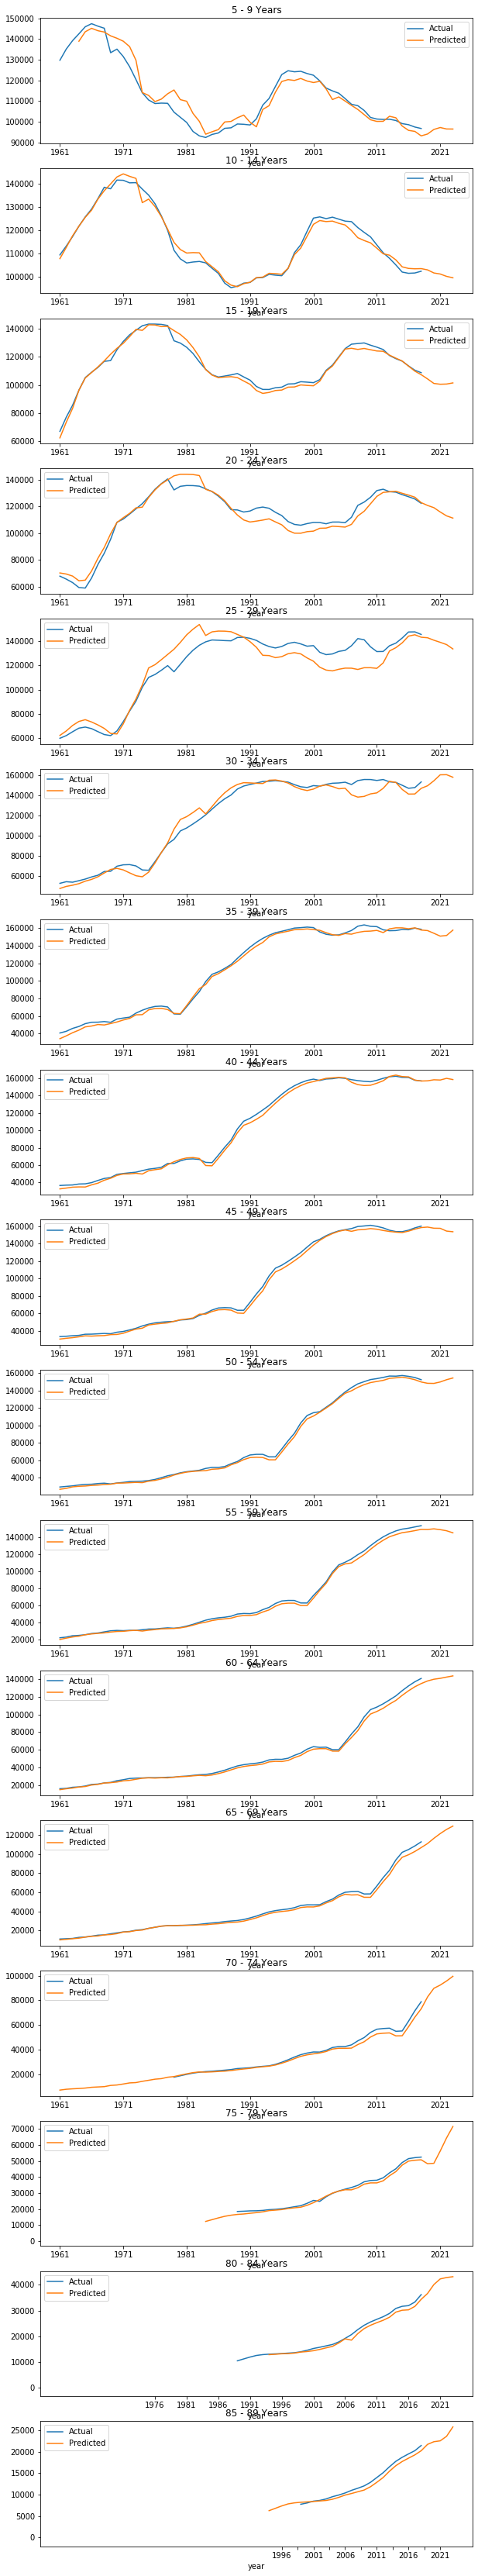

In [31]:

fig,ax = plt.subplots(len(female_pop.columns)-1,1,figsize=(10,60))
for i in range(len(female_pop.columns)-1):
    female_pop.loc['1962':].iloc[:,1:].iloc[:,i].plot(ax=ax[i])
    fm_predicted.iloc[:,i].plot(ax=ax[i])
    ax[i].set_title(fm_predicted.iloc[:,i].name)
    ax[i].legend(['Actual','Predicted'])

##### 5. To further extend the prediction, we will need to get newborns prediction

Get female fertility of specific ages

In [22]:
fertility = fer_rate_ts.iloc[:,6:][~fer_rate_ts.iloc[:,7].isna()]
fert_predicted = []
for y in list(fm_predicted.loc[female_pop.index[-1]:].index):
    fert_predicted += [np.dot(fm_predicted.iloc[:,2:8].loc[y]/1000,fertility.loc[y])]
temp = pd.DataFrame(list(zip([str(y) for y in np.array(int(female_pop.index[-1])) + [i for i in range(1,len(fert_predicted) +1)]],fert_predicted))).rename(columns={0:'year',1:totallifebirth.name}).set_index('year')
extend_newborns = pd.concat([pd.DataFrame(totallifebirth),temp])
year1_4 = female_pop.iloc[:,0] - totallifebirth/2

##### 6 . Using 3 years of past new borns to predict 1-4 years old

In [27]:
beta0_1 = backward_reg2(totallifebirth/2,year1_4,reg=[1,2,3])
betas[' 1 - 4 Years'] = beta0_1

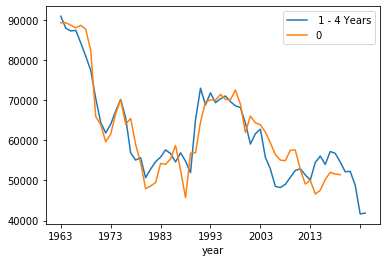

In [29]:
past = 3
ind = [str(i) for i in (np.array([int(y) for y in extend_newborns.index]) + 3)]
pred14 = pd.DataFrame(zip(ind,np.dot(prepare_x(extend_newborns/2,period=range(1,past+1)),beta0_1))).rename(columns={0:'year',1:' 1 - 4 Years'}).set_index('year')
ax = pred14.plot()
pd.DataFrame(year1_4).rename(columns={0:'Actual 1-4 yo'}).loc['1963':].plot(ax=ax)

### 4. Generate prediction

#### 4.1 Structure all ideas into a class function

In [4]:

class gen_pop():
    
    def __init__(self):
        self._INTERCEPT = False
        self._EXTRA_FERTILITY = 6

        self.betas_male = {}
        self.betas_female = {}


    def generate(self,year_to_gen):
        pop_gender = pd.read_excel('pop_by_gender.xlsx',skiprows=5).iloc[:75,:]
        
        female_pop = pop_gender.iloc[list(range(51,69))+[-1],:]
        male_pop = pop_gender.iloc[list(range(26,44))+[-1],:]

        # there is a discrepancy between fertility provided and actual lifebirth, so we will add some extra fertility rate
        female_pop = female_pop.set_index('Variables').transpose()



        for col in female_pop.columns:
            female_pop[col] = fillnb(female_pop[col])

        male_pop = male_pop.set_index('Variables').transpose()

        for col in male_pop.columns:
            male_pop[col] = fillnb(male_pop[col])



        # GET ACTUAL LIFE BIRTH
        totallifebirth = fer_rate.set_index(' Variables ').loc[' Total Live-births (Number) '].apply(lambda x: int(re.sub(',','',x)))
        try:
            fertility = pd.read_csv('fertility_rate.csv').set_index('index')
            fertility.index = fertility.index.astype(str)
                                                     
        except:
            fertility = fer_rate_ts.iloc[:,6:][~fer_rate_ts.iloc[:,7].isna()] #ready made

        # we will use both male and female 1-4 years old, to reg the relationship to new borns
        # TODO make use of mortality
        temp = female_pop.iloc[:,0] + male_pop.iloc[:,0] - totallifebirth
        beta0_1 = backward_reg2(totallifebirth,temp,reg=[1,2,3],intercept=self._INTERCEPT)
        self.betas_female[' 1 - 4 Years'] = beta0_1 #both male and female newborn to next group will be using same coef for simplicity
        self.betas_male[' 1 - 4 Years'] = beta0_1

        # first column of female pop is 0-4 years old, we will remove newborn from here, even though it predicts better with 0-4 years
        # but what we re trying to do now is predict newborns

        # we will divide total life birth into 0.5, As stated in the paper, an assumed sex ratio at birth is used to divide total births into males and females

        female_pop.iloc[:,0] = female_pop.iloc[:,0] - totallifebirth/2 
        female_pop = female_pop.rename(columns={ '0 - 4 Years' : ' 1 - 4 Years'})
        male_pop.iloc[:,0] = male_pop.iloc[:,0] - totallifebirth/2
        male_pop = male_pop.rename(columns={ '0 - 4 Years' : ' 1 - 4 Years'})

        reg_on = 5 # number of years before to use for regression, for 5-9 years above , on previous age group

    
        f_reference = female_pop.copy()
        m_reference = male_pop.copy()


        for ncol in range(1,len(female_pop.columns)):
            self.betas_female[female_pop.iloc[:,ncol].name] = backward_reg2(female_pop.iloc[:,ncol-1],female_pop.iloc[:,ncol],reg=reg_on,intercept=self._INTERCEPT)

        for ncol in range(1,len(male_pop.columns)):
            self.betas_male[male_pop.iloc[:,ncol].name] = backward_reg2(male_pop.iloc[:,ncol-1],male_pop.iloc[:,ncol],reg=reg_on,intercept=self._INTERCEPT)

        latest_year = int(female_pop.index[-1])
        #---------------------------------------
        #Above are the preparation steps, below will be generating steps

        roundd =0 
        self.store = []
        while int(female_pop.index[-1]) < latest_year + year_to_gen:
            
            

            fm_predicted = pd.DataFrame()
            for ncol in range(1,len(female_pop.columns)):

                fm_predicted = pd.concat([fm_predicted,pd.DataFrame(pop_forecast(self.betas_female[female_pop.iloc[:,ncol].name],female_pop.iloc[:,ncol-1],reg_on,intercept=self._INTERCEPT)).rename(columns={0:'year',1:female_pop.iloc[:,ncol].name}).set_index('year')],axis=1)
                
            m_predicted = pd.DataFrame()
            for ncol in range(1,len(male_pop.columns)):
                m_predicted = pd.concat([m_predicted,pd.DataFrame(pop_forecast(self.betas_male[male_pop.iloc[:,ncol].name],male_pop.iloc[:,ncol-1],reg_on,intercept=self._INTERCEPT)).rename(columns={0:'year',1:male_pop.iloc[:,ncol].name}).set_index('year')],axis=1)
            



            #fert_predicted will be a list of prediction of newborns
            fert_predicted = []
            for y in list(fm_predicted.loc[female_pop.index[-1]:].index):
                fert_predicted += [np.dot(fm_predicted.iloc[:,2:8].loc[y]/1000,fertility.loc[y] + self._EXTRA_FERTILITY)]


            #new borns for next few years , make it into dataframe and concat with actual lifebirth
            temp = pd.DataFrame(list(zip([str(y) for y in np.array(int(female_pop.index[-1])) + [i for i in range(1,len(fert_predicted) +1)]],fert_predicted))).rename(columns={0:'year',1:totallifebirth.name}).set_index('year')
            
            # extend newborns with latest years
            extend_newborns = pd.concat([pd.DataFrame(totallifebirth),temp])

            #so with future newborns, we will predict future 1-4 years old, then we can get new population
            # we used 3 lags of previous newborns newborn to predict current 1-4 years old
            past = 3
            ind = [str(i) for i in (np.array([int(y) for y in extend_newborns.index]) + 3)]
            pred14 = pd.DataFrame(zip(ind,np.dot(prepare_x(extend_newborns/2,period=range(1,past+1),intercept=self._INTERCEPT),beta0_1))).rename(columns={0:'year',1:' 1 - 4 Years'}).set_index('year')


            # since female_predicted starts from 5-9, we will concat 1-4 group to them
            female_pop = pd.concat([pred14,fm_predicted],axis=1)
            female_pop = female_pop[~female_pop[' 1 - 4 Years'].isna()]

            #same for male
            male_pop = pd.concat([pred14,m_predicted],axis=1)
            male_pop = male_pop[~male_pop[' 1 - 4 Years'].isna()]

            # update total life birth
            totallifebirth = extend_newborns.iloc[:,0]


            
            #since the function pop_forecast give all years fitted values , we will replace with those previous with non null actual values 
            # if not we will be accumulating regression error and keep rolling
            for col in female_pop.columns:
                for y in female_pop[col].index:
                    if y not in list(f_reference.index):
                        pass
                    else:
                        if (math.isnan(f_reference[col].loc[y]) == False) :
#                         & (math.isnan(female_pop[col].loc[y])):
                            female_pop[col].loc[y] = f_reference[col].loc[y]

            for col in male_pop.columns:
                for y in male_pop[col].index:
                    if y not in list(m_reference.index):
                        pass
                    else:
                        if (math.isnan(m_reference[col].loc[y]) == False) :
#                         & (math.isnan(male_pop[col].loc[y])):
                            male_pop[col].loc[y] = m_reference[col].loc[y]


#             female_pop = pd.concat([f_reference, female_pop.loc[f_reference.index[-1]:]])
        
        
        self.female_pop = female_pop
        self.male_pop = male_pop
        self.newborns = extend_newborns
        self.pred14 = pred14
        self.beta0_1 = beta0_1
        
        
    def output_weights(self):
        with open('female_betas.pickle','wb') as handle:
            pickle.dump(self.betas_female,handle)
        with open('male_betas.pickle','wb') as handle:
            pickle.dump(self.betas_male,handle)
        np.save('beta_newborns.npy',self.beta0_1)


#### 4.2 Declare parameters for object

In [7]:
output = gen_pop()
output._INTERCEPT = True
output.generate(30)

Save weights

In [110]:
output.output_weights()

#### 4.3 Show 10 year forecast result 
Overall population result vs real , discrepancy is caused by incomplete actual data (early years)

Text(0.5, 1.0, 'Actual vs predicted population')

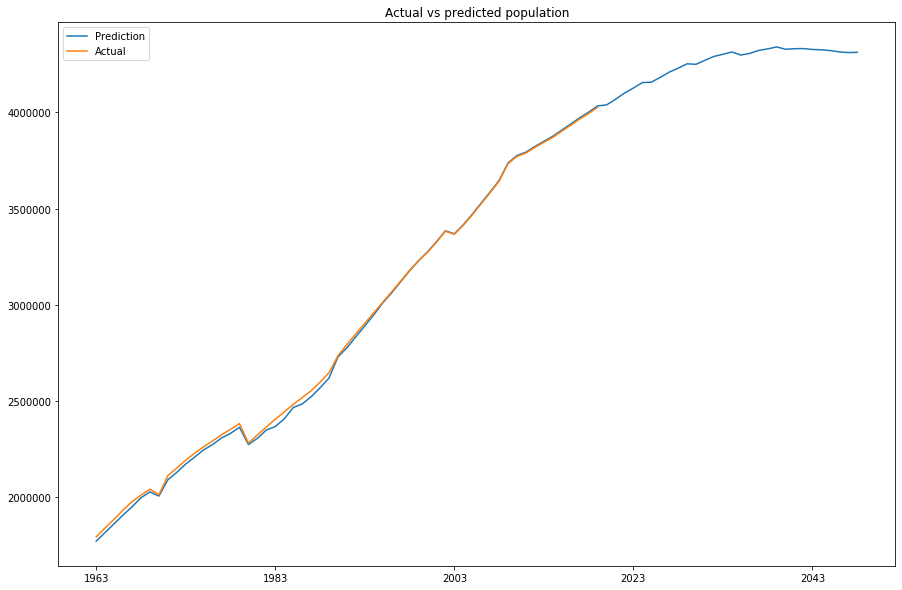

In [7]:
predicted = ((output.female_pop + output.male_pop).sum(axis=1) + output.newborns.iloc[:,0])
total = pop_gender.set_index('Variables').transpose().iloc[:,0]
ax = predicted.loc['1963':predicted.index[-2]].plot(figsize=(15,10))
ax.plot(total.loc['1963':])

ax.legend(['Prediction','Actual'])
ax.set_title('Actual vs predicted population')


In [16]:

def get_pop_longdata(output):

    
    temp = pd.merge((output.newborns //2).reset_index() , output.female_pop.loc[:list(output.female_pop.index)[-2]].reset_index(),on='index')
    temp['0 - 4 Years'] = temp[' Total Live-births (Number) '] + temp[' 1 - 4 Years']
    temp = temp.drop([' Total Live-births (Number) ', ' 1 - 4 Years'],1)
    temp = temp.set_index('index')
    temp = temp[[list(temp.columns)[-1]]+list(temp.columns)[:-1]]
    temp = temp.reset_index()
    temp = temp.rename(columns={'index':'year'})

    temp = pd.melt(temp, id_vars='year',value_vars=list(temp.columns)[1:]).rename(columns={'variable':'age_group','value':'population'})
    temp['gender'] = 'Female'
    
    temp2 = pd.merge((output.newborns //2).reset_index() , output.male_pop.loc[:list(output.male_pop.index)[-2]].reset_index(),on='index')
    temp2['0 - 4 Years'] = temp2[' Total Live-births (Number) '] + temp2[' 1 - 4 Years']
    temp2 = temp2.drop([' Total Live-births (Number) ', ' 1 - 4 Years'],1)
    temp2 = temp2.set_index('index')
    temp2 = temp2[[list(temp2.columns)[-1]]+list(temp2.columns)[:-1]]
    temp2 = temp2.reset_index()
    temp2 = temp2.rename(columns={'index':'year'})

    temp2 = pd.melt(temp2, id_vars='year',value_vars=list(temp2.columns)[1:]).rename(columns={'variable':'age_group','value':'population'})
    temp2['gender'] = 'Male'
    
    return pd.concat([temp,temp2])


pop_group = get_pop_longdata(output)


    
    


In [150]:
pop_group.to_csv('../NUHS Workload/population_national_est.csv',index=False)

In [361]:
np.save(file='beta0_1.npy',arr=output.beta0_1)

### 5. Validating our methodology and output

United Nation and World Bank forecasted Singapore population.

Total population consists of resident and non resident, our model only took care of residents forecast by cohort component approach, we will get non resident estimate by simply doing nonlinear fitting

So we have matched our non resident + resident data for 2018 with world bank:  5638673.0
And UN data stated 5.757 mil
Based on world bank projection, sg population will peak in 2043 with 6.45m, for our prediction it will be in 2037 , 4.24 mil
So we are about right that it will not be linearly extrapolated.


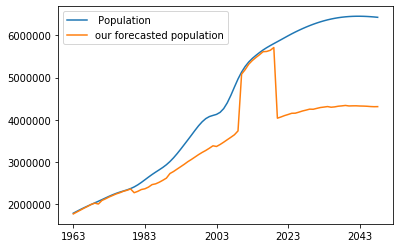

In [51]:
#UN data , 5.85 in 2019
#world bank , 5.639 in 2018, UN 5.757 in 2018

nonresident = np.array([1305.01,1394.44,1494.23,1554.41,1598.99,1632.31,1673.72,1646.46,1644.39,1677.36])*1000
nonresident = pd.concat([pd.Series(list(range(2010,2020))).astype(str),pd.Series(nonresident)],axis=1).rename(columns={0:'year',1:'non_resident_pop'}).set_index('year')

# here we get non resident data from somewhere in the paper??? , it matches with world bank stats.


un = pd.read_csv('singapore-population-2020-06-10.csv')
un['date'] = un['date'].apply(lambda x: str(datetime.strptime(x,'%d/%m/%Y').year))
un  = un.set_index('date')

# we only have non resident pop 10 to 19, lets try and see if they match with UN total population



temp = pd.concat([predicted.loc[:predicted.index[-2]],nonresident],axis=1).rename(columns={0:'resident'})
temp = temp[~temp['resident'].isna()].fillna(0)
temp['our forecasted population'] = temp['resident'] + temp['non_resident_pop']


temp = pd.concat([un,temp['our forecasted population']],axis=1).rename(columns={0:'predicted'})
temp = temp[~temp['our forecasted population'].isna()]
temp.drop(' Annual Growth Rate',1).plot()

So we have matched our non resident + resident data for 2018 with world bank, 5638673,
and UN data stated 5.757 mil.

Based on world bank projection, sg population will peak in 2043 with 6.45m (resident + non resident), for our prediction(resident only) it will be in 2037 , 4.24 mil 

From the plot above, after 1983 and before 2019, the gap maybe the increase in non resident, unfortunately we only get non resident data from 2010, we will backtrack from here, since our 2010 data onwards matches (the part when blue and orange meets in the middle)


#### Non resident estimation

1. We only have official non resident from 2010 onwards.
2. After we added our non resident data from 2010 with our resident population, we match with world bank numbers.
3. So it probably means we can get actual data by differencing world bank and our resident data from 1963

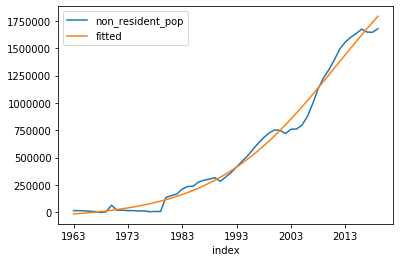

In [38]:
from scipy.optimize import curve_fit

def sigmoid(x,l,x0,k,b):
    y = l/(1+ np.exp(-k*(x-x0))) +b
    return y

# get non resident data from the difference between UN data and our actual resident data
nonresident = pd.concat([pd.DataFrame(temp[' Population'] - temp['population']).loc[:'2009'].rename({0:'non_resident_pop'},axis=1), nonresident])

ydata = nonresident['non_resident_pop'].to_numpy()
xdata = nonresident.index.astype(int)
result =  curve_fit(sigmoid,xdata,ydata,[max(ydata),np.median(xdata),1,min(ydata)],method='dogbox')

l,x0,k,b = result[0]
nonresident = nonresident.reset_index()
nonresident['fitted'] = nonresident['index'].apply(lambda x: sigmoid(int(x),l,x0,k,b))
nonresident.plot(x='index',y=['non_resident_pop','fitted'])


After estimating the function of non residents, we add it into our forecast

Only able to get UN forecast data, so we will compare to UN

UN forecast of Singapore residents population vs Our forecast (until 2043)

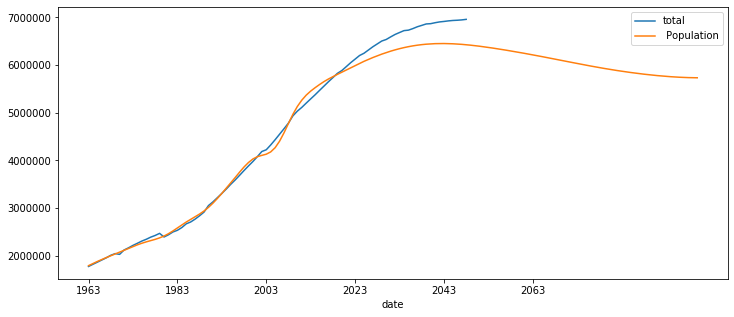

In [39]:
all_pop = pd.DataFrame(predicted).reset_index().rename(columns={0:'resident'})
all_pop['nonresident'] = all_pop['index'].apply(lambda x: sigmoid(int(x),l,x0,k,b)).apply(lambda x: 0 if x<0 else x)
all_pop = all_pop[~all_pop['resident'].isna()].set_index('index')
all_pop['total'] = all_pop['resident'] + all_pop['nonresident']
all_pop = all_pop.loc[:all_pop.index[-2]]

ax = all_pop[['total']].plot(figsize=(12,5))
un[[' Population']].loc[all_pop.index[0]:].plot(ax=ax)

Result from the forecast function

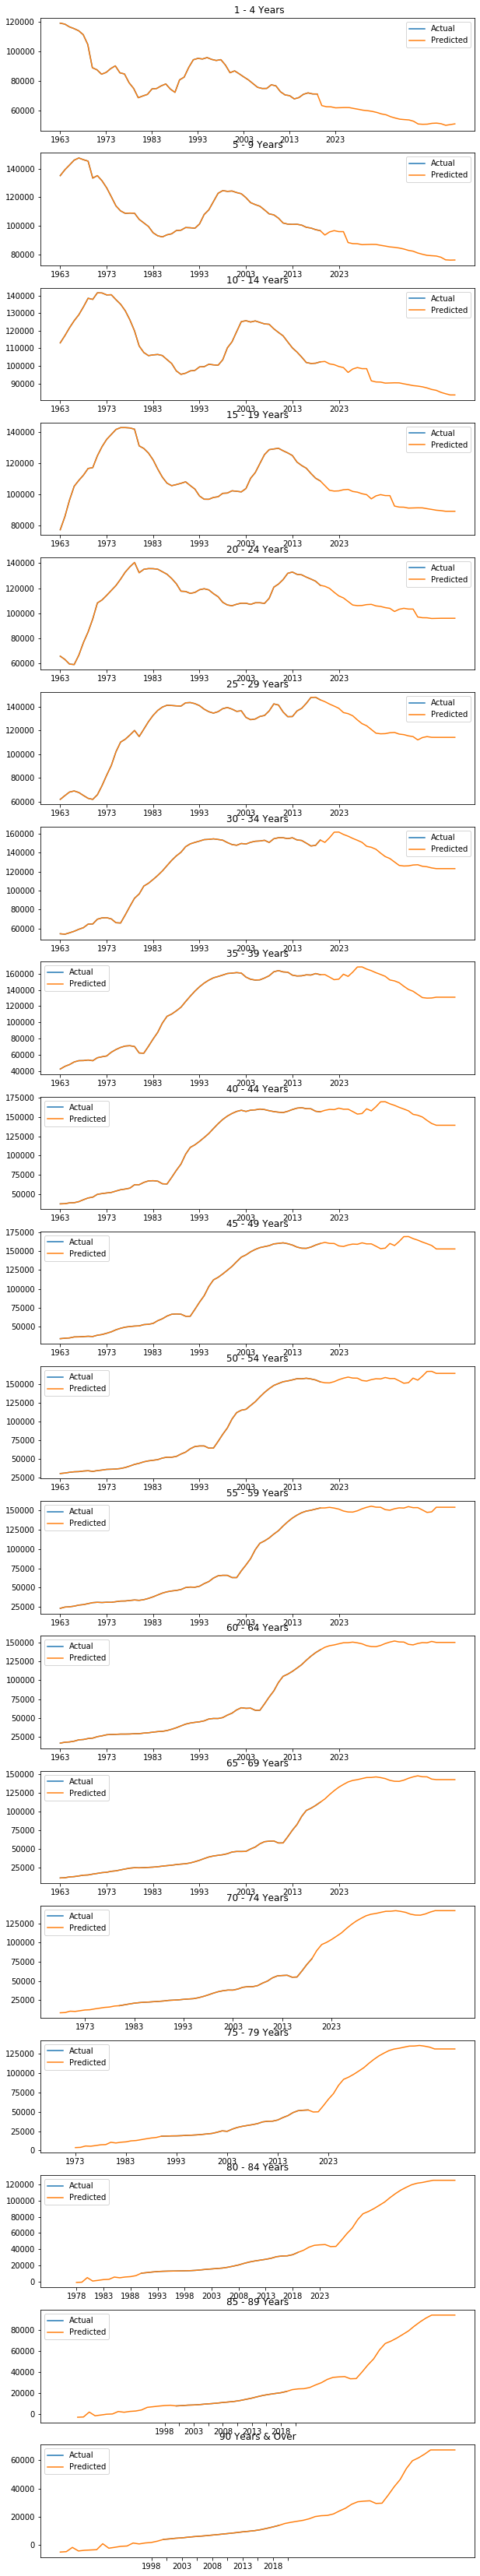

In [303]:

fig,ax = plt.subplots(len(female_pop.columns),1,figsize=(10,60))
for i in range(len(female_pop.columns)):
    female_pop.loc['1963':].iloc[:,i].plot(ax=ax[i])
    output.female_pop.iloc[:,i].plot(ax=ax[i])
    ax[i].set_title(female_pop.iloc[:,i].name)
    ax[i].legend(['Actual','Predicted'])

### 6. Limitation
####  Fertility rate discrepancy

Take number of females recorded in the past, divide by 1000 and multiply with fertility rate , we still have some different result compare to the new borns recorded obtained in another dataset on Singstat.  

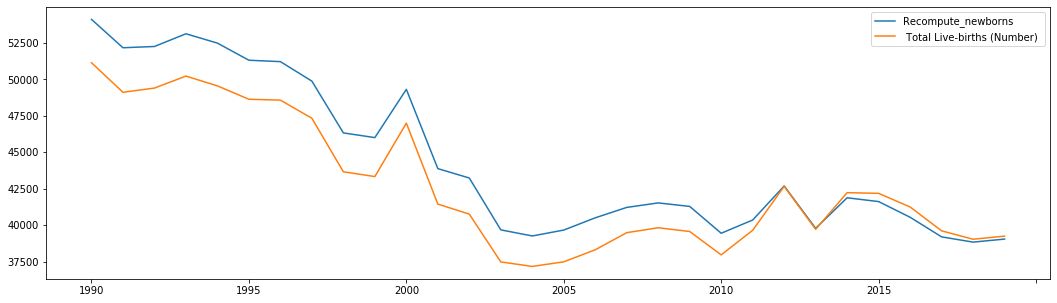

In [277]:
recalc_life = []
for y in list(female_pop.index):
    try:
        recalc_life += [(y,math.ceil(np.dot((female_pop.shift(0).iloc[:,3:9]//1000).loc[y].to_numpy(),fertility.loc[y].to_numpy() +6)))]
    except:
        pass
recalc_life = pd.DataFrame(recalc_life).rename(columns={0:'year',1:'Recompute_newborns'}).set_index('year')


pd.concat([recalc_life,totallifebirth],axis=1).loc[:'2019'].plot(figsize=(18,5))

Showcasing the forecast of newborns (in blue)

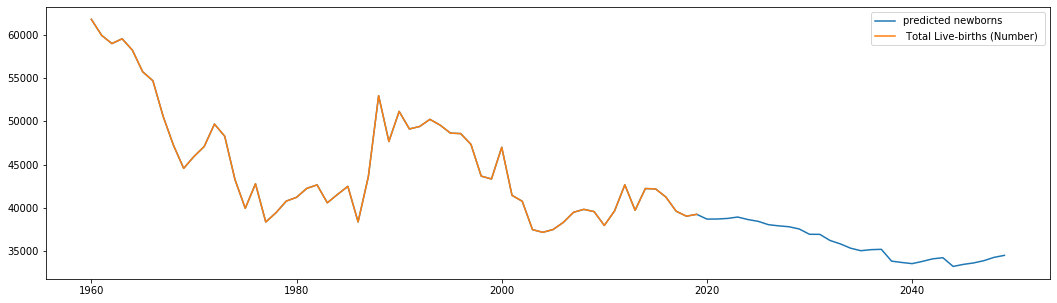

In [59]:
pd.concat([output.newborns.rename(columns={' Total Live-births (Number) ':'predicted newborns'}),totallifebirth],axis=1).plot(figsize=(18,5))

### 7. Appendix

#### Actual population plot visualization

Because population plot is hard to visualize, so i merged them together, x-axis here doesnt mean anything after i shifted the plots.

(1) What we can see from here is that 0-4 group has the largest curvature, since they were most affected by changes in fertility. And then subsequently in the next 5 years, we can see some falls for 5-9 group, and subsequently for other older group. But as the group gets further away from 0-4, they have more cushion so they have less curvature, "cushion" means that they have a lot of younger people after them, to fill up the group statistics. So for example 30-34 group looks like there were no significant drop throughout the years.

(2) The bands are tighter together at the early part, and become more diverse in later part. 

(3) older the age group, the replacement rate is more stable, Less volatile, so the band the total value is higher than younger age group, because it accumulates more.

Now we have mortality rate, and next we want to find out replacement rate. A rate for younger people to come in , and older people to come out of the group. The entrance rate is higher in the early part. 

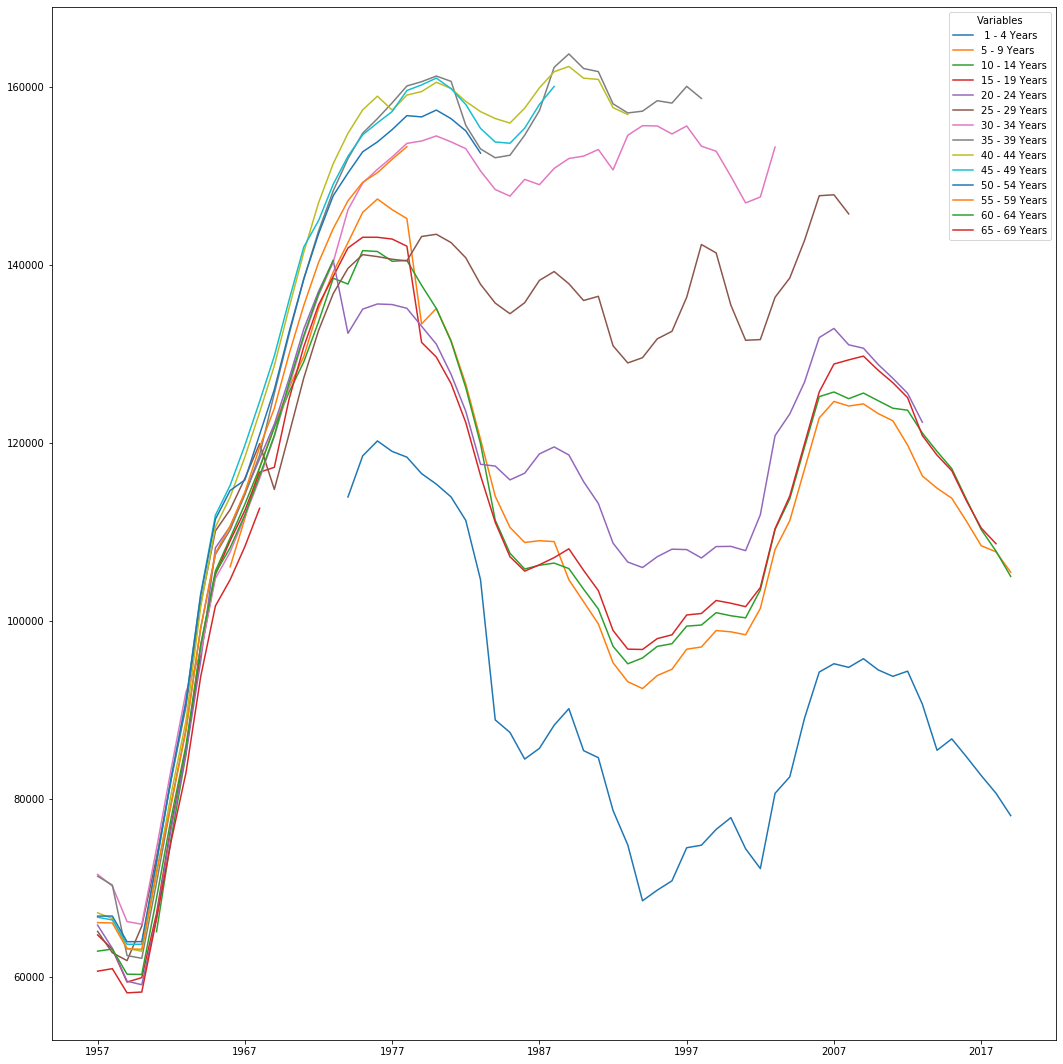

In [1528]:
temp = female_pop.iloc[:,:-4].copy()
ncol = len(temp.columns)
for i,col in enumerate(temp.columns):
    temp[col] = temp[col].shift(ncol-((i)*5))
temp.plot(figsize=(18,19))

Not always linear, why> a new batch go into this group could have sudden large number of surge, but the group oldest people leaving to next group might not be just little. Becasue our yearly sample is not independent.

If we scatter plot 5 years comparison, we see more straight lines scatter plot than 1 year comparison, because mostly everyone from the younger group would move to older group in 5 years

So if we look at one plot, the middle section always line up better than two ends, because the middle section is those points during 1960++ 

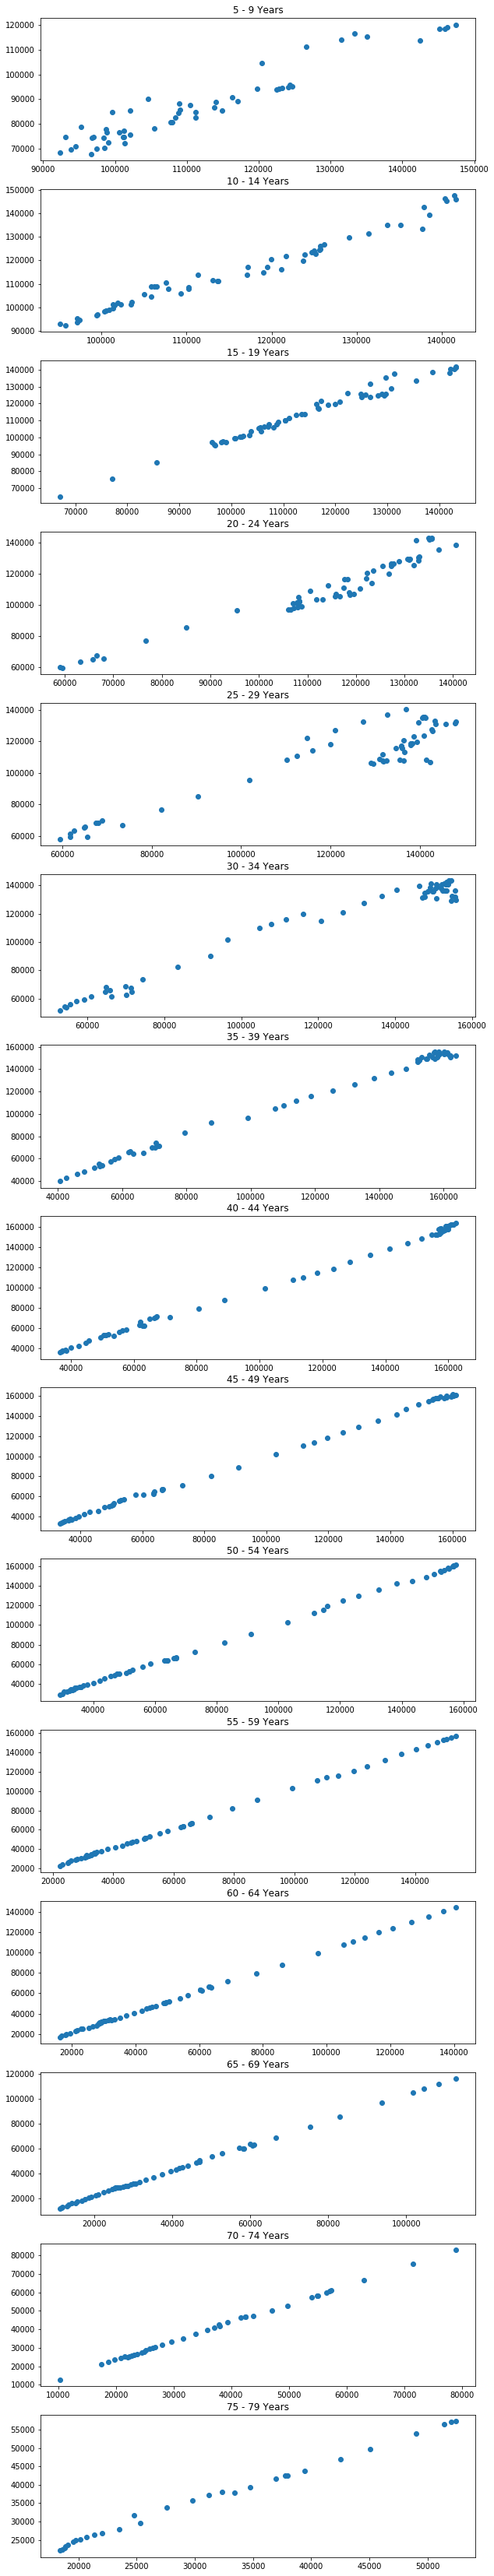

In [1533]:
fig,ax = plt.subplots(15,1,figsize=(10,60))
for i in range(1,16):
    tmp = female_pop.iloc[:,i].apply(lambda x: math.nan if x == 'na' else x)
    tmp2 = female_pop.iloc[:,i-1].apply(lambda x: math.nan if x == 'na' else x)
    ax[i-1].scatter(tmp,tmp2.shift(5))
    ax[i-1].set_title(tmp.name)